In [1]:
import struct
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Chunk:
    __header_size = 8;
    header = None
    data_position = -1
    fd = None
    def __init__(self,file):
        initial_pos = file.tell()
        self.header=file.read(self.__header_size)
        if not self.header:
            raise EOFError("EOF reached")
        if self.header[6]!=0x60 or self.header[7]!=0xc0:
            file.seek(initial_pos,0)
            raise LookupError("Chunk Header should end with 0x60c0")
        self.data_size = (self.header[1]*256 ) + self.header[0]
        self.nframe  = self.header[5]*0xff + self.header[4]
        self.type = self.header[3]
        self.data_position = file.tell()
        file.seek(self.data_size,1)
        self.fd=file
    
    def get_data(self):
        initial_pos = self.fd.tell()
        self.fd.seek(self.data_position,0)
        result = self.fd.read(self.data_size)
        self.fd.seek(initial_pos,0)
        return result
        

In [4]:
class VIPFile:
    fd = None
    filename = ""
    chunks = []
    initial_offset = 0x20
    def __init__(self,filename,initial_offset=0x20,max_chunks=-1):
        self.filename = filename
        self.fd = open(filename,"rb")
        self.initial_offset = initial_offset
        self.max_chunks=max_chunks
    
    def __del__(self):
        if self.fd:
            self.fd.close()
            
    def anal_vip_file(self):
        self.fd.seek(0,0)
        self.fd.seek(self.initial_offset,1)
        while True:
            try:
                tmp_chunk = Chunk(self.fd)
                self.chunks.append(tmp_chunk)
                if self.max_chunks>0 and self.max_chunks<len(self.chunks):
                    break
            except EOFError as e:
                break
            except Exception as e:
                print(e)
                raise e
            
    def show_info(self,init=0,end=-1,filter_by=[]):
        if end<0:
            end=len(self.chunks)
        for count,bh in  enumerate(self.chunks[init:end]):
            h=bh.header
            endset = "💩💩💩💩💩💩💩💩💩💩💩"
            size=bh.data_size
            
            text=""
            for i,b in enumerate(h):
                text+=f"{b:02x} " 
                if i==3:
                    if b==4:
                        endset = "🗝️"
                    elif b==7:
                        endset = "🎵"
                    elif b==2 :
                        endset = "🎨"
                    elif b==5:
                        endset = "🎬"
            if endset in filter_by or len(filter_by)==0:
                print(f"{count+init:06}: [{size:>6}]",end=" ")
                print(f"{text} {endset}")
            
            
            
    def pinta_paleta(self,id):
        paleta=self.get_paleta(id)
        #pintaremos
        colors = [x for x in range(len(paleta))]
        while len(colors)<256:
            colors.append(0)
        pal =  np.array( paleta ,dtype="uint8") 
        indices = np.array(colors)
        plt.imshow(pal[indices].reshape( (16,16,3) ) )
        
    def get_paleta(self,id):
        raw = self.chunks[id].get_data()
        paleta = []
        paleta.append((0,0,0))
        i=2
        while True:
            try:
                r,g,b = raw[i:i+3] # leemos RGB
                i+=3
                paleta.append( (r*4,g*4,b*4))
            except Exception as e:
                break
        return paleta
        
        
    
        

In [5]:
#f.seek(0x0DF5B6A0,0)
#f.seek(0x0135a684,0)

v =VIPFile("../data/game/iso/SN00002.VIP",0x0DF5B6A0,50000)

In [6]:
v.anal_vip_file()

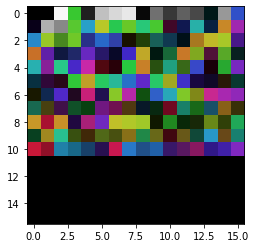

In [7]:
v.pinta_paleta(0)

In [8]:
228*140

31920

In [30]:
v.show_info(0,50000,["🎨","🗝️"])

000000: [   529] 11 02 00 02 f0 d2 60 c0  🎨
000001: [   560] 30 02 02 04 f0 d2 60 c0  🗝️
000644: [   580] 44 02 00 02 9c d4 60 c0  🎨
000645: [   560] 30 02 02 04 9c d4 60 c0  🗝️
001006: [   577] 41 02 00 02 8c d5 60 c0  🎨
001355: [   577] 41 02 00 02 74 d6 60 c0  🎨
001806: [   574] 3e 02 00 02 a0 d7 60 c0  🎨
001807: [   897] 81 03 02 04 a0 d7 60 c0  🗝️
002788: [   577] 41 02 00 02 2e da 60 c0  🎨
003212: [  8049] 71 1f 02 04 48 db 60 c0  🗝️
004742: [   577] 41 02 00 02 44 df 60 c0  🎨
004743: [ 41143] b7 a0 02 04 44 df 60 c0  🗝️


In [35]:
hex(len(v.get_paleta(4742)))

'0xc0'

In [40]:
raw1 = v.chunks[4743].get_data()

In [41]:
with open("puede_que_un_keyframe_4743.frm","wb") as f:
    f.write(raw1)

In [42]:
raw2 = []

for i,r in enumerate(list(raw1)):
    if i%2 == 0:
        raw2.append(0x0)
        continue
    if r>0xc0:
        raw2.append(0xFF)
    else:
        raw2.append(r)

In [43]:
with open("puede_que_un_keyframe_4743b.frm","wb") as f:
    f.write(np.array(raw2,dtype="uint8"))

In [15]:



def draw_image_with_paleta(paleta,img,size):
    pal =  np.array( paleta ,dtype="uint8") 
    indices = np.array(img,dtype="uint8")
    plt.imshow(pal[indices].reshape( (size[0],size[1],3) ) )


In [16]:
pal =None 
with open("../data/game/iso/FILES/FINALPAL.PPS","rb") as fpal:
    data=fpal.read()
    pal = data[2:]
    
paleta = []
paleta.append( (0,0,0))
i=0
while True:
    try:
        r,g,b = pal[i:i+3] # leemos RGB
        i+=3
        paleta.append( (r*4,g*4,b*4))
    except Exception as e:
        break

In [17]:
raw =None 
with open("../data/game/iso/FILES/FINALPAN.PSP","rb") as fpal:
    data=fpal.read(4)
    w = data[1]*256+data[0]
    h = data[3]*256+data[2]
    raw=list(fpal.read(w*h))

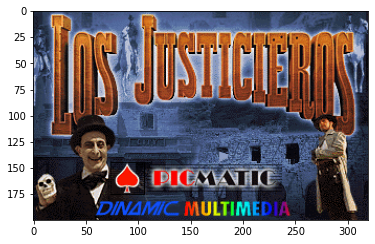

In [18]:
draw_image_with_paleta(paleta,raw,(h,w))



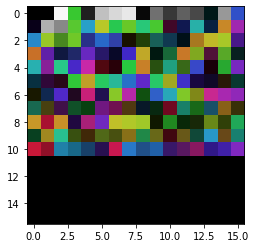

In [19]:
v.pinta_paleta(0)

In [20]:
v.show_info(0,30000,["🗝️"])

000001: [   560] 30 02 02 04 f0 d2 60 c0  🗝️
000645: [   560] 30 02 02 04 9c d4 60 c0  🗝️
001807: [   897] 81 03 02 04 a0 d7 60 c0  🗝️
003212: [  8049] 71 1f 02 04 48 db 60 c0  🗝️
004743: [ 41143] b7 a0 02 04 44 df 60 c0  🗝️


In [21]:
mypal = v.get_paleta(0)

In [22]:
raw=v.chunks[1].get_data()

In [23]:
hex(57),hex(35)
0x1ff,0x01e3

0x230/4

140.0

In [24]:
rawpar = [ x for i,x in enumerate(list(raw)) if i%2==0]
len(rawpar)
rawpar[:10]

[255, 227, 255, 227, 255, 227, 255, 227, 255, 227]

In [25]:
sum(rawpar),228*140

(67480, 31920)

In [26]:
draw_image_with_paleta(mypal,list(rawpar),(3,10))


IndexError: index 255 is out of bounds for axis 0 with size 176

In [ ]:
raw = v.chunks[3212].get_data()

In [ ]:
with open("puede_que_un_keyframe_3212.frm","wb") as f:
    f.write(raw)

In [ ]:
raw2 = []

for r in list(raw):
    if r<200:
        raw2.append(0x11)
    else:
        raw2.append(r)

In [ ]:
with open("puede_que_un_keyframe_3b.frm","wb") as f:
    f.write(np.array(raw2,dtype="uint8"))

In [ ]:
len(raw2),len(raw)

In [ ]:
np.array(raw2)